In [1]:
from statistics import mean
from statistics import stdev
import time
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


import shap
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Clean_Data.csv', low_memory=False)

In [3]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972006 entries, 0 to 972005
Columns: 233 entries, atlas_pct_laccess_child15 to race_cd
dtypes: float64(150), int64(14), object(69)
memory usage: 1.7+ GB


# Scaling of Columns

In [5]:
df1 = df.copy(deep = True)

In [6]:
counter = 1
for col in df1.columns:
    if df1[col].dtypes != 'object' and df1[col].skew() > 50 :   # Can possibly add .nunique to prevent categorical column transformation
        print(f"{counter}--{col} --> {df1[col].skew()}")
        df1.drop(col, inplace=True, axis =1)
        counter += 1

1--rx_gpi2_01_pmpm_cost_0to3m_b4 --> 89.40635856793378
2--auth_3mth_acute_inj --> 193.34415314735676
3--auth_3mth_acute_hdz --> 110.90947418742948


In [7]:
counter = 1
for col in df1.columns:
    if df1[col].dtypes != 'object' and df1[col].skew() > 10:
        print(f"{counter}--{col} --> {df1[col].skew()}")
        df1[col] = np.log(df1[col]+1)
        print(f"{counter}--{col} --> {df1[col].skew()}")
        counter += 1

1--rx_bh_mbr_resp_pmpm_cost_9to12m_b4 --> 26.244866229426414
1--rx_bh_mbr_resp_pmpm_cost_9to12m_b4 --> 2.7971629519748897
2--atlas_pct_laccess_nhna15 --> 39.95444675343169
2--atlas_pct_laccess_nhna15 --> 6.856492893948924
3--cmsd2_sns_digest_abdomen_pmpm_ct --> 12.636059361542928
3--cmsd2_sns_digest_abdomen_pmpm_ct --> 5.89871638886969
4--total_outpatient_allowed_pmpm_cost_6to9m_b4 --> 15.347177890814114
4--total_outpatient_allowed_pmpm_cost_6to9m_b4 --> 1.313192098155918
5--rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4 --> 19.93987101778713
5--rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4 --> 1.5411348564113632
6--ccsp_236_pct --> 11.526178560090557
6--ccsp_236_pct --> 7.882739114884116
7--rx_nonmaint_mbr_resp_pmpm_cost --> 24.115146330045842
7--rx_nonmaint_mbr_resp_pmpm_cost --> 1.1176904463936221
8--rx_gpi2_02_pmpm_cost --> 25.05073130468443
8--rx_gpi2_02_pmpm_cost --> 4.80101822846315
9--rev_pm_obsrm_pmpm_ct --> 14.17401874188251
9--rev_pm_obsrm_pmpm_ct --> 9.377724534861756
10--rx_nonbh_mbr

In [8]:
counter = 1
for col in df1.columns:
    if df1[col].dtypes != 'object':
        print(f"{counter}--{col}--->{df[col].skew()}----> {df1[col].skew()}")
        counter += 1

1--atlas_pct_laccess_child15--->0.8298853310596424----> 0.8298853310596424
2--atlas_pct_free_lunch14--->0.27947226996040203----> 0.27947226996040203
3--cons_chmi--->1.8096192918700325----> 1.8096192918700325
4--credit_bal_nonmtgcredit_60dpd--->1.2803933477020708----> 1.2803933477020708
5--rx_bh_mbr_resp_pmpm_cost_9to12m_b4--->26.244866229426414----> 2.7971629519748897
6--atlas_pct_laccess_nhna15--->39.95444675343169----> 6.856492893948924
7--credit_hh_nonmtgcredit_60dpd--->0.6684623358037446----> 0.6684623358037446
8--rx_bh_pmpm_ct_0to3m_b4--->3.7978832799191906----> 3.7978832799191906
9--cons_lwcm10--->0.9271531013617893----> 0.9271531013617893
10--cmsd2_sns_digest_abdomen_pmpm_ct--->12.636059361542928----> 5.89871638886969
11--credit_hh_bankcardcredit_60dpd--->0.8535837371858481----> 0.8535837371858481
12--total_outpatient_allowed_pmpm_cost_6to9m_b4--->15.347177890814114----> 1.313192098155918
13--cons_cwht--->0.1912860402851905----> 0.1912860402851905
14--atlas_netmigrationrate1016-

In [9]:
col_list = ['bh_ncdm_ind','bh_ncal_ind','race_cd']


counter = 0
for col in col_list:
    df1[col] = df1[col].astype(str)
    print(f"{counter} {col} --> {df1[col].unique()} --> {df1[col].dtypes}")
    counter += 1 

0 bh_ncdm_ind --> ['0' '1'] --> object
1 bh_ncal_ind --> ['0.0' '0.6931471805599453'] --> object
2 race_cd --> ['1.0' '5.0' '0.0' '2.0' '3.0' '4.0' '6.0'] --> object


# Feature Selection

In [10]:
#White = 1 and Others = 0
def race(x):
    if x == '1.0':
        return 'White'
    else:
        return 'Others'

df1["race_cd"] = np.vectorize(race)(df1['race_cd'])

In [11]:
df1["race_cd"].astype(str)

0          White
1          White
2          White
3          White
4          White
           ...  
972001    Others
972002     White
972003     White
972004     White
972005     White
Name: race_cd, Length: 972006, dtype: object

In [50]:
def age(x):
    if x >= 80:
        return 'Above 80'
    elif 65 <= x < 80 :
        return '65 to 79'
    elif 50<= x <65:
        return '50 to 64'
    elif 35<=x<50:
        return '35 to 49'
    else:
        return 'Below 35'

df1["age_bracket"] = np.vectorize(age)(df1['est_age'])

In [51]:
df1["stra_col"] = df1["age_bracket"].astype(str) + "_" + df1["race_cd"].astype(str) + "_" + df1["covid_vaccination"].astype(str)

In [52]:
df1.head()

,atlas_pct_laccess_child15,atlas_pct_free_lunch14,total_bh_copay_pmpm_cost_t_9-6-3m_b4,cons_chmi,mcc_ano_pmpm_ct_t_9-6-3m_b4,rx_maint_pmpm_cost_t_12-9-6m_b4,cons_ltmedicr,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,rx_nonbh_pmpm_cost_t_9-6-3m_b4,...,mcc_end_pct,cons_lwcm07,atlas_perpov_1980_0711,atlas_pct_laccess_white15,rx_gpi2_66_pmpm_ct,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4,atlas_low_education_2015_update,race_cd,age_bracket,stra_col
0,7.910346,46.839102,No Activity,67.0,No Activity,Inc_1x-2x,4.0,2366.225593,0.000000,Dec_1x-2x,...,0.0,0.23359,0.0,26.842903,0.000000,Inc_1x-2x,0.0,White,65 to 79,65 to 79_White_no_vacc
1,1.730272,36.721923,No Activity,69.0,No Activity,No Activity,3.0,2926.079093,0.000000,New,...,0.0,0.19198,0.0,11.405128,0.000000,New,0.0,White,65 to 79,65 to 79_White_no_vacc
2,5.015501,39.605015,No Activity,76.0,No Activity,Dec_2x-4x,Category_X,4522.696898,0.157004,New,...,0.0,0.44111,0.0,1.713138,0.083333,Inc_1x-2x,0.0,White,35 to 49,35 to 49_White_no_vacc
3,4.049586,93.694818,No Activity,46.0,No Activity,Inc_1x-2x,8.0,3993.478363,0.000000,Dec_1x-2x,...,0.0,0.15418,0.0,11.853595,0.000000,Dec_1x-2x,0.0,White,65 to 79,65 to 79_White_no_vacc
4,0.618606,36.298252,No Activity,111.0,No Activity,Inc_1x-2x,4.0,1336.755009,0.000000,Inc_2x-4x,...,0.0,0.16355,0.0,33.795298,0.000000,Dec_1x-2x,0.0,White,65 to 79,65 to 79_White_no_vacc


In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df1, df1["stra_col"]):
    strat_train_set = df1.loc[train_index]
    strat_test_set = df1.loc[test_index]

In [54]:
X_strat_train = strat_train_set.drop(['covid_vaccination','est_age','stra_col'], axis=1) # drop labels for training set
y_strat_train = strat_train_set['covid_vaccination'].copy()

In [55]:
y_strat_train = y_strat_train.replace(['vacc','no_vacc'], [0,1])

In [56]:
X_strat_test = strat_test_set.drop(['covid_vaccination','est_age','stra_col'], axis=1) # drop labels for testing set
y_strat_test = strat_test_set['covid_vaccination'].copy()
y_strat_test = y_strat_test.replace(['vacc','no_vacc'], [0,1])

In [57]:
categorical_bolean = (X_strat_train.dtypes == "object").values
training_categorical = X_strat_train.loc[:,categorical_bolean]
training_numerical = X_strat_train.loc[:,~categorical_bolean]

In [58]:
categorical_column = list(training_categorical)
numerical_column = list(training_numerical)

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler # StandardScaler
from sklearn.preprocessing import OrdinalEncoder  #Can try we one-hot later


full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), numerical_column),
        ("cat", OrdinalEncoder(), categorical_column),
    ])

X_strat_train_prepared = full_pipeline.fit_transform(X_strat_train)


In [60]:
orderd_col = numerical_column + categorical_column

In [61]:
orderd_col

['atlas_pct_laccess_child15',
 'atlas_pct_free_lunch14',
 'cons_chmi',
 'credit_bal_nonmtgcredit_60dpd',
 'rx_bh_mbr_resp_pmpm_cost_9to12m_b4',
 'atlas_pct_laccess_nhna15',
 'credit_hh_nonmtgcredit_60dpd',
 'rx_bh_pmpm_ct_0to3m_b4',
 'cons_lwcm10',
 'cmsd2_sns_digest_abdomen_pmpm_ct',
 'credit_hh_bankcardcredit_60dpd',
 'total_outpatient_allowed_pmpm_cost_6to9m_b4',
 'cons_cwht',
 'atlas_netmigrationrate1016',
 'atlas_pct_laccess_snap15',
 'rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4',
 'atlas_naturalchangerate1016',
 'ccsp_236_pct',
 'atlas_pct_laccess_hisp15',
 'rx_overall_mbr_resp_pmpm_cost',
 'rx_overall_gpi_pmpm_ct_0to3m_b4',
 'atlas_pct_laccess_hhnv15',
 'credit_bal_consumerfinance',
 'rwjf_uninsured_pct',
 'rx_mail_mbr_resp_pmpm_cost_0to3m_b4',
 'ccsp_193_pct',
 'rx_nonmaint_mbr_resp_pmpm_cost',
 'atlas_vlfoodsec_13_15',
 'rx_gpi2_34_dist_gpi6_pmpm_ct',
 'credit_hh_bankcard_severederog',
 'rx_hum_16_pmpm_ct',
 'cnt_cp_webstatement_pmpm_ct',
 'atlas_pct_laccess_seniors15',
 'phy_em_

In [62]:
len(orderd_col)

229

In [63]:
len(X_strat_train.columns)

229

In [64]:
X_strat_train.head()

,atlas_pct_laccess_child15,atlas_pct_free_lunch14,total_bh_copay_pmpm_cost_t_9-6-3m_b4,cons_chmi,mcc_ano_pmpm_ct_t_9-6-3m_b4,rx_maint_pmpm_cost_t_12-9-6m_b4,cons_ltmedicr,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,rx_nonbh_pmpm_cost_t_9-6-3m_b4,...,days_since_last_clm_0to3m_b4,mcc_end_pct,cons_lwcm07,atlas_perpov_1980_0711,atlas_pct_laccess_white15,rx_gpi2_66_pmpm_ct,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4,atlas_low_education_2015_update,race_cd,age_bracket
560933,4.751929,66.746519,No Activity,30.000000,No Activity,Inc_1x-2x,9.0,2310.760877,0.000000,Inc_1x-2x,...,4,0.000000,0.358090,0.0,25.936218,0.0,Dec_1x-2x,0.0,White,65 to 79
343765,7.952891,39.993662,No Activity,57.000000,No Activity,No_Change,8.0,5419.717011,0.000000,Dec_1x-2x,...,120,0.000000,0.290480,0.0,13.169722,0.0,Dec_1x-2x,0.0,White,65 to 79
107791,6.690833,55.036625,No Activity,64.000000,No Activity,No Activity,4.0,1809.135545,0.000000,No Activity,...,120,0.000000,0.319640,0.0,11.800400,0.0,No Activity,0.0,White,65 to 79
903469,4.742359,38.922717,No Activity,65.932554,No Activity,Inc_1x-2x,Category_X,3850.321009,1.814825,Dec_1x-2x,...,13,0.316636,0.246768,0.0,13.891726,0.0,Dec_1x-2x,0.0,White,65 to 79
963355,3.808013,52.462429,No Activity,80.000000,No Activity,No_Change,6.0,3010.511187,0.000000,Dec_2x-4x,...,12,0.000000,0.235230,0.0,17.730690,0.0,No_Change,0.0,White,65 to 79


In [65]:
X_strat_train_prepared_DataFrame = pd.DataFrame(X_strat_train_prepared, columns = orderd_col)
X_strat_train_prepared_DataFrame.head()

,atlas_pct_laccess_child15,atlas_pct_free_lunch14,cons_chmi,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_nhna15,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,cons_lwcm10,cmsd2_sns_digest_abdomen_pmpm_ct,...,atlas_persistentchildpoverty_1980_2011,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4,bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4,atlas_perpov_1980_0711,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4,atlas_low_education_2015_update,race_cd,age_bracket
0,-0.084292,1.168817,-1.429802,-0.265505,-0.418470,-0.488473,0.356626,-0.435769,1.214618,-0.271061,...,0.0,4.0,0.0,9.0,3.0,0.0,0.0,0.0,1.0,2.0
1,1.102953,-0.477214,-0.355457,2.615688,-0.418470,-0.265443,1.265439,-0.435769,0.774387,-0.271061,...,1.0,9.0,0.0,11.0,8.0,0.0,0.0,0.0,1.0,2.0
2,0.634853,0.448339,-0.076923,-0.730381,-0.418470,-0.017055,-0.518815,-0.435769,0.855028,0.502131,...,0.0,9.0,0.0,9.0,8.0,0.0,9.0,0.0,1.0,2.0
3,-0.087842,-0.543107,-0.000025,1.161266,2.068448,-0.368634,0.077842,2.441544,-0.000188,-0.271061,...,0.0,0.0,0.0,9.0,4.0,0.0,0.0,0.0,1.0,2.0
4,-0.434393,0.289955,0.559726,0.382981,-0.418470,-0.416606,0.017671,-0.435769,0.321930,-0.271061,...,0.0,10.0,0.0,9.0,7.0,0.0,10.0,0.0,1.0,2.0


In [66]:
X_strat_train[['total_bh_copay_pmpm_cost_t_9-6-3m_b4','race_cd','total_physician_office_visit_ct_pmpm_t_6-3-0m_b4','rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4','age_bracket']].tail(70)

,total_bh_copay_pmpm_cost_t_9-6-3m_b4,race_cd,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4,age_bracket
964089,No Activity,White,Resolved,Dec_1x-2x,Above 80
598657,No Activity,White,No Activity,Dec_1x-2x,65 to 79
5207,No Activity,White,No Activity,New,65 to 79
714594,No Activity,White,No Activity,Inc_1x-2x,65 to 79
575751,No Activity,White,No Activity,Resolved,65 to 79
...,...,...,...,...,...
564017,No Activity,White,No_Change,No_Change,Above 80
491682,No Activity,White,No Activity,Resolved,Above 80
151800,No Activity,White,No Activity,No_Change,Below 35
696417,No Activity,White,No Activity,No Activity,65 to 79


In [67]:
X_strat_train['age_bracket'].value_counts()

65 to 79    512647
Above 80    146422
50 to 64     79528
35 to 49     29353
Below 35      9654
Name: age_bracket, dtype: int64

In [68]:
X_strat_train_prepared_DataFrame[['total_bh_copay_pmpm_cost_t_9-6-3m_b4','race_cd','total_physician_office_visit_ct_pmpm_t_6-3-0m_b4','rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4','age_bracket']].head(10)

,total_bh_copay_pmpm_cost_t_9-6-3m_b4,race_cd,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4,age_bracket
0,9.0,1.0,3.0,4.0,2.0
1,9.0,1.0,8.0,9.0,2.0
2,9.0,1.0,8.0,9.0,2.0
3,9.0,1.0,4.0,0.0,2.0
4,9.0,1.0,7.0,10.0,2.0
5,9.0,1.0,8.0,5.0,2.0
6,9.0,1.0,8.0,6.0,1.0
7,9.0,1.0,8.0,4.0,2.0
8,9.0,1.0,0.0,8.0,3.0
9,9.0,1.0,0.0,4.0,3.0


In [70]:
X_strat_test_prepared = full_pipeline.transform(X_strat_test)

In [71]:
#from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
model = xgb.XGBClassifier()

# define random forest classifier
#forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#forest.fit(X_strat_train_prepared, y_strat_train)

In [72]:
from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, max_iter=50, random_state=1)

# find all relevant features
feat_selector.fit(X_strat_train_prepared, y_strat_train)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_strat_train_prepared)

[02:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	229
Rejected: 	0
[02:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	229
Rejected: 	0
[03:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set e

In [73]:
feature_name = orderd_col

In [74]:
feature_ranks = list(zip(feature_name, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
boruta_col = []
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
    if feat[2] == True:
        boruta_col.append(feat[0]) 

Feature: atlas_pct_laccess_child15 Rank: 135,  Keep: False
Feature: atlas_pct_free_lunch14    Rank: 21,  Keep: False
Feature: cons_chmi                 Rank: 65,  Keep: False
Feature: credit_bal_nonmtgcredit_60dpd Rank: 36,  Keep: False
Feature: rx_bh_mbr_resp_pmpm_cost_9to12m_b4 Rank: 83,  Keep: False
Feature: atlas_pct_laccess_nhna15  Rank: 70,  Keep: False
Feature: credit_hh_nonmtgcredit_60dpd Rank: 1,  Keep: True
Feature: rx_bh_pmpm_ct_0to3m_b4    Rank: 1,  Keep: True
Feature: cons_lwcm10               Rank: 83,  Keep: False
Feature: cmsd2_sns_digest_abdomen_pmpm_ct Rank: 50,  Keep: False
Feature: credit_hh_bankcardcredit_60dpd Rank: 2,  Keep: False
Feature: total_outpatient_allowed_pmpm_cost_6to9m_b4 Rank: 94,  Keep: False
Feature: cons_cwht                 Rank: 92,  Keep: False
Feature: atlas_netmigrationrate1016 Rank: 36,  Keep: False
Feature: atlas_pct_laccess_snap15  Rank: 109,  Keep: False
Feature: rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4 Rank: 11,  Keep: False
Feature: atla

In [75]:
boruta_col

['credit_hh_nonmtgcredit_60dpd',
 'rx_bh_pmpm_ct_0to3m_b4',
 'rx_overall_gpi_pmpm_ct_0to3m_b4',
 'credit_bal_consumerfinance',
 'atlas_vlfoodsec_13_15',
 'credit_hh_bankcard_severederog',
 'cnt_cp_webstatement_pmpm_ct',
 'rwjf_uninsured_adults_pct',
 'lab_albumin_loinc_pmpm_ct',
 'rev_pm_obsrm_pmpm_ct',
 'atlas_pct_sfsp15',
 'cms_tot_partd_payment_amt',
 'rx_nonbh_mbr_resp_pmpm_cost',
 'rx_days_since_last_script',
 'rwjf_uninsured_child_pct',
 'atlas_net_international_migration_rate',
 'atlas_foodinsec_child_03_11',
 'cons_nwperadult',
 'rx_generic_mbr_resp_pmpm_cost',
 'lab_dist_loinc_pmpm_ct',
 'atlas_pct_nslp15',
 'rx_generic_pmpm_ct_0to3m_b4',
 'rx_overall_mbr_resp_pmpm_cost_0to3m_b4',
 'rx_tier_2_pmpm_ct_3to6m_b4',
 'rx_maint_pmpm_ct_9to12m_b4',
 'cms_risk_adjustment_factor_a_amt',
 'rx_generic_pmpm_cost',
 'rx_generic_pmpm_cost_6to9m_b4',
 'rx_nonbh_pmpm_ct_0to3m_b4',
 'rx_tier_1_pmpm_ct_0to3m_b4',
 'cons_estinv30_rc',
 'atlas_pct_sbp15',
 'atlas_pct_cacfp15',
 'pdc_lip',
 'rx_ti

In [76]:
X_test_filtered = feat_selector.transform(X_strat_test_prepared)

In [77]:
selected_boruta_col = X_strat_train_prepared_DataFrame.columns[feat_selector.support_]

# GradientBoostingClassifier

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

clf_boruta_2 = GradientBoostingClassifier(n_estimators=1500, learning_rate=0.01, max_depth=5, random_state=0)
clf_boruta_2.fit(X_filtered, y_strat_train)


roc_auc_score(y_strat_test, clf_boruta_2.predict_proba(X_test_filtered)[:, 1])

0.67832554521714

In [79]:
roc_auc_score(y_strat_test, clf_boruta_2.predict_proba(X_test_filtered)[:, 1])

0.67832554521714

In [80]:
from sklearn.metrics import accuracy_score
y_pred = clf_boruta_2.predict(X_test_filtered)
accuracy_score(y_strat_test, y_pred)

0.8262775074330511

In [81]:
from sklearn.metrics import log_loss

clf_boruta_2_probas = clf_boruta_2.predict_proba(X_test_filtered)
log_loss(y_strat_test, clf_boruta_2_probas)

0.4321465498638011

In [82]:
clf_boruta_2.classes_

array([0, 1], dtype=int64)

In [83]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred,labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    #plt.savefig(filename,  bbox_inches='tight')


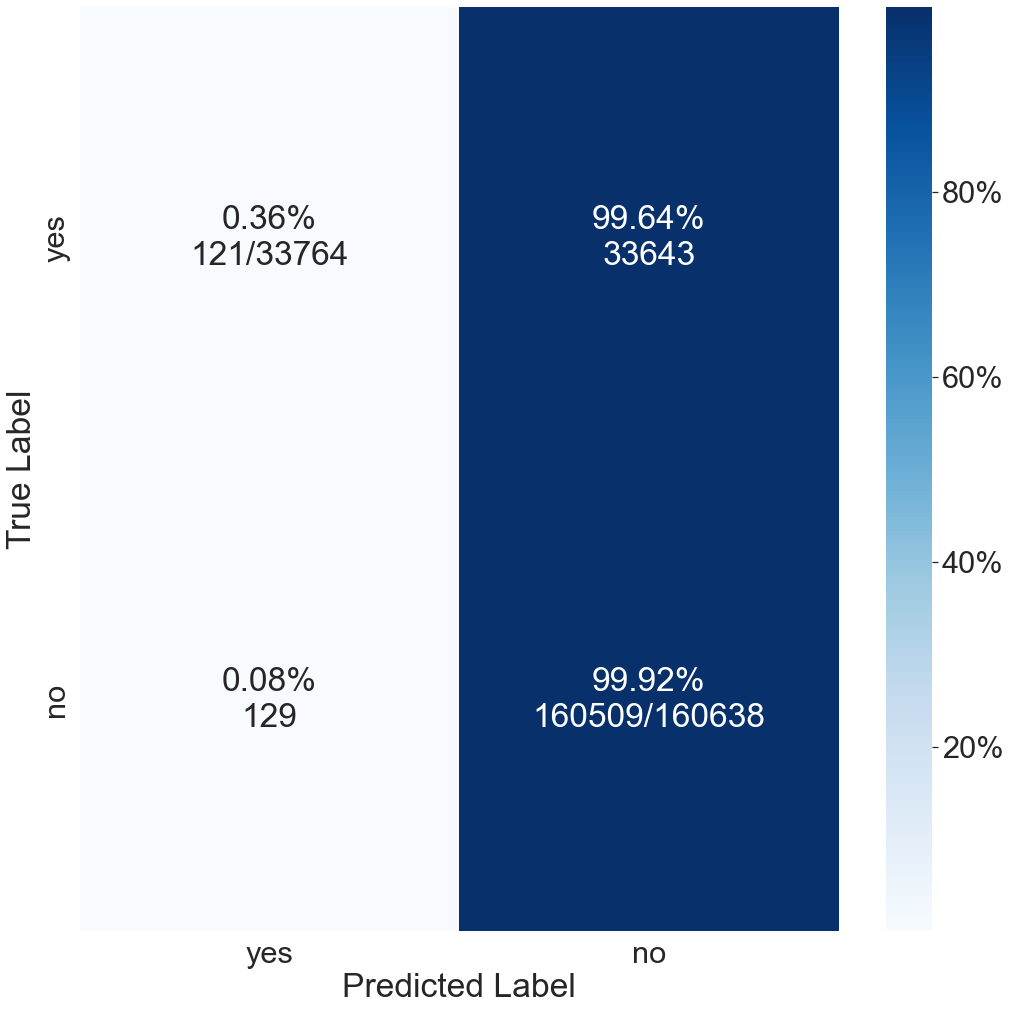

In [84]:
cm_analysis(y_strat_test, y_pred, labels = clf_boruta_2.classes_ , classes = ['yes','no'])

# LogisticRegression

In [85]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(X_filtered, y_strat_train)

roc_auc_score(y_strat_test, lr_model.predict_proba(X_test_filtered)[:, 1])

0.6503816927776229

In [86]:
lr_model_y_pred = lr_model.predict(X_test_filtered)
accuracy_score(y_strat_test, lr_model_y_pred)

0.8263443791730538

In [87]:
from sklearn.metrics import log_loss

lr_model_probas = lr_model.predict_proba(X_test_filtered)
log_loss(y_strat_test, lr_model_probas)

0.44114349885991105

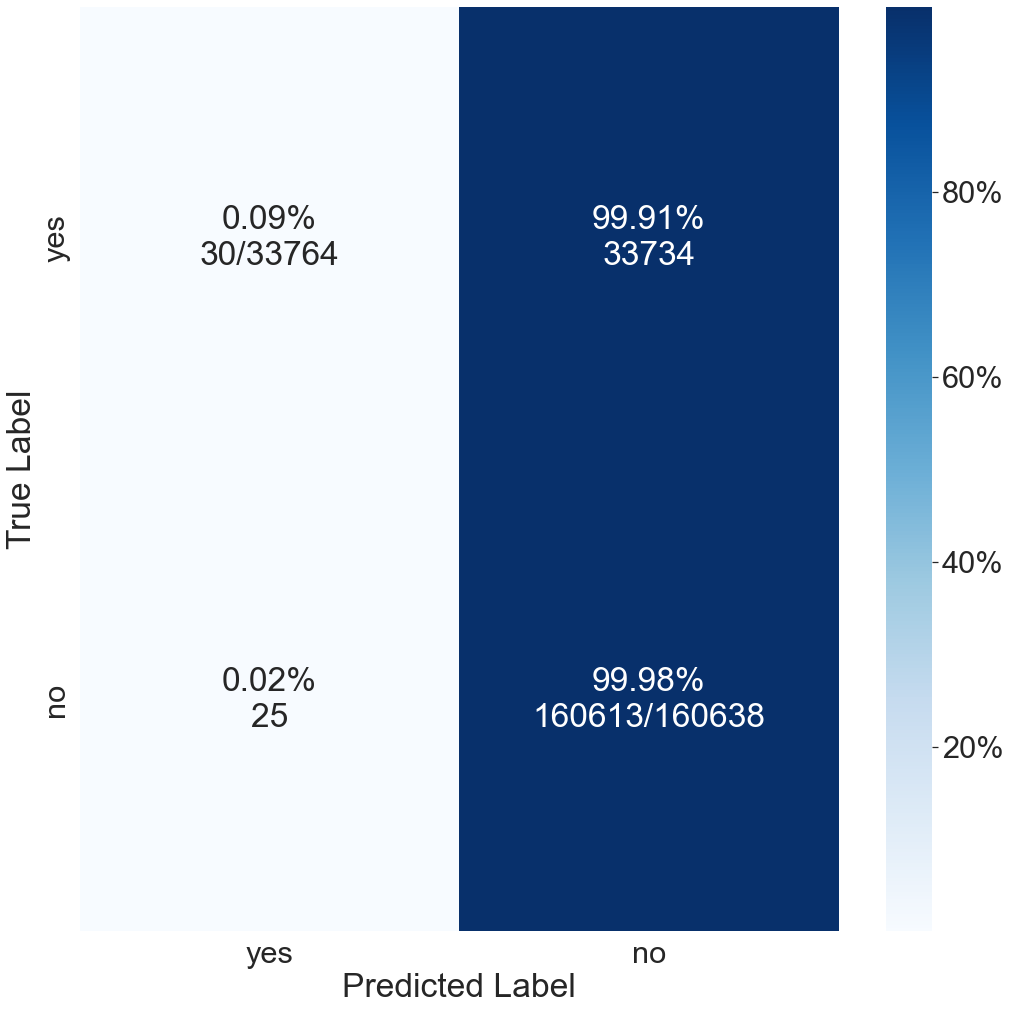

In [88]:
cm_analysis(y_strat_test, lr_model_y_pred, labels = lr_model.classes_ , classes = ['yes','no'])

# XG Boost

In [89]:
from statistics import mean
from statistics import stdev
import time
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [90]:
import xgboost as xgb


model_1 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_1.fit(X_filtered, y_strat_train)
roc_auc_score(y_strat_test, model_1.predict_proba(X_test_filtered)[:, 1])

[12:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6790812995836075

In [91]:
y_pred = model_1.predict(X_test_filtered)
accuracy_score(y_strat_test, y_pred)

0.8263392351930535

In [92]:
from sklearn.metrics import log_loss

model_1_probas = model_1.predict_proba(X_test_filtered)
log_loss(y_strat_test, model_1_probas)

0.43173974514823005

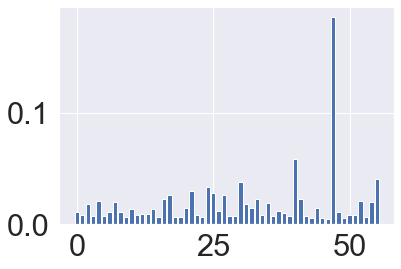

In [93]:
from matplotlib import pyplot

pyplot.bar(range(len(model_1.feature_importances_)), model_1.feature_importances_)
pyplot.show()

In [94]:
counter = 0
for col in selected_boruta_col:
    print(f"{counter}==> {col}")
    counter +=1

0==> credit_hh_nonmtgcredit_60dpd
1==> rx_bh_pmpm_ct_0to3m_b4
2==> rx_overall_gpi_pmpm_ct_0to3m_b4
3==> credit_bal_consumerfinance
4==> atlas_vlfoodsec_13_15
5==> credit_hh_bankcard_severederog
6==> cnt_cp_webstatement_pmpm_ct
7==> rwjf_uninsured_adults_pct
8==> lab_albumin_loinc_pmpm_ct
9==> rev_pm_obsrm_pmpm_ct
10==> atlas_pct_sfsp15
11==> cms_tot_partd_payment_amt
12==> rx_nonbh_mbr_resp_pmpm_cost
13==> rx_days_since_last_script
14==> rwjf_uninsured_child_pct
15==> atlas_net_international_migration_rate
16==> atlas_foodinsec_child_03_11
17==> cons_nwperadult
18==> rx_generic_mbr_resp_pmpm_cost
19==> lab_dist_loinc_pmpm_ct
20==> atlas_pct_nslp15
21==> rx_generic_pmpm_ct_0to3m_b4
22==> rx_overall_mbr_resp_pmpm_cost_0to3m_b4
23==> rx_tier_2_pmpm_ct_3to6m_b4
24==> rx_maint_pmpm_ct_9to12m_b4
25==> cms_risk_adjustment_factor_a_amt
26==> rx_generic_pmpm_cost
27==> rx_generic_pmpm_cost_6to9m_b4
28==> rx_nonbh_pmpm_ct_0to3m_b4
29==> rx_tier_1_pmpm_ct_0to3m_b4
30==> cons_estinv30_rc
31==> atl

# Random Forest Classifier

# Shap Analysis

In [95]:
shap.initjs()

In [96]:
explainer = shap.TreeExplainer(clf_boruta_2)
shap_values = explainer.shap_values(X_filtered)

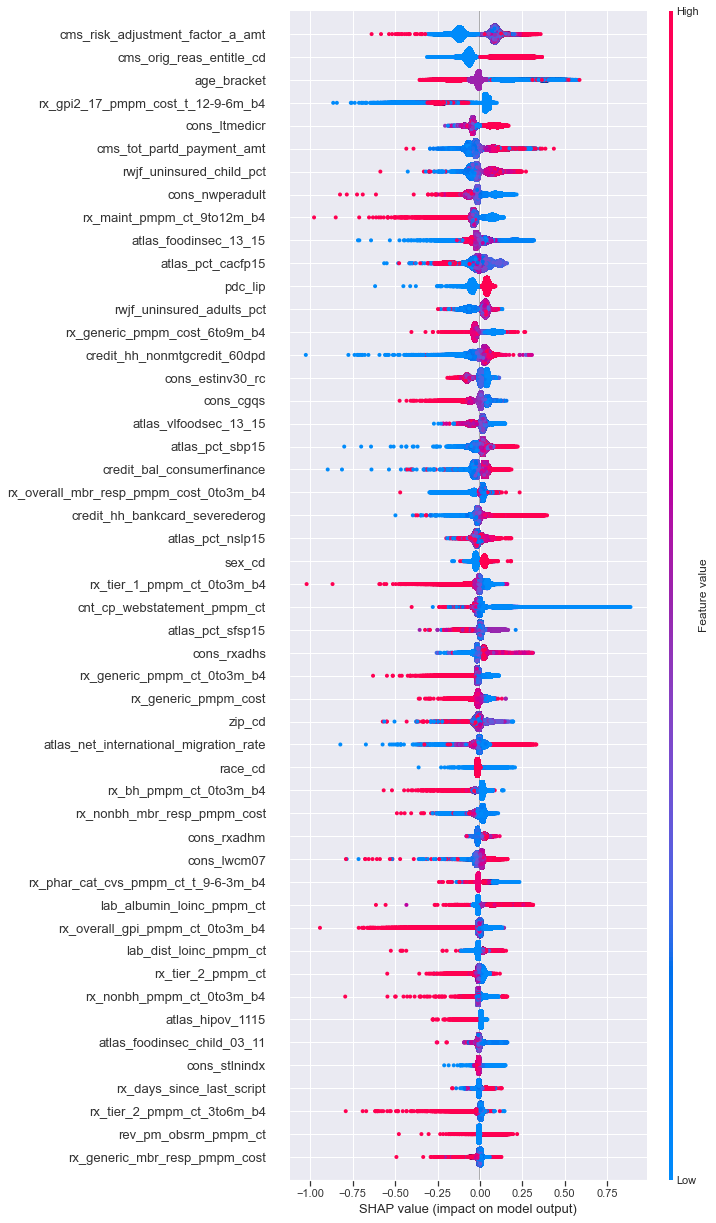

In [97]:
#shap.summary_plot(shap_values, features=X_filtered, feature_names=boruta_col)
shap.summary_plot(shap_values, X_filtered, feature_names = selected_boruta_col, max_display = 50)

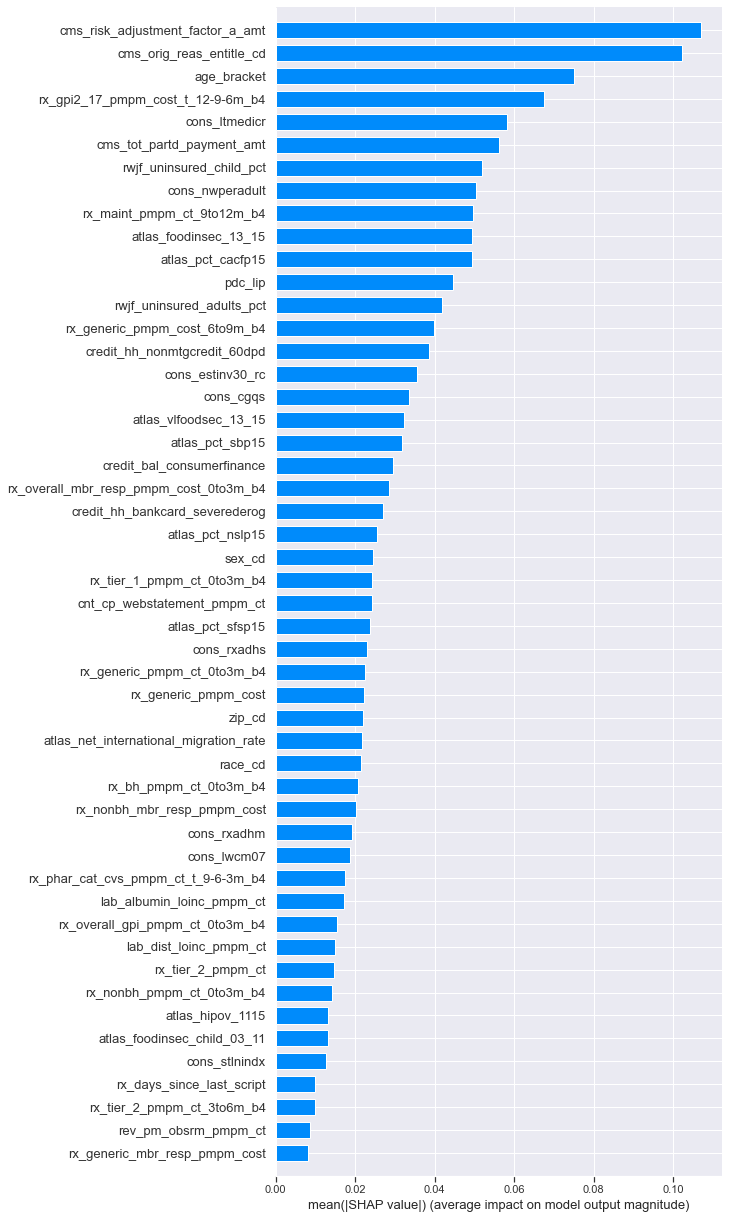

In [98]:
shap.summary_plot(shap_values, X_filtered, plot_type='bar',feature_names = boruta_col, max_display = 50)

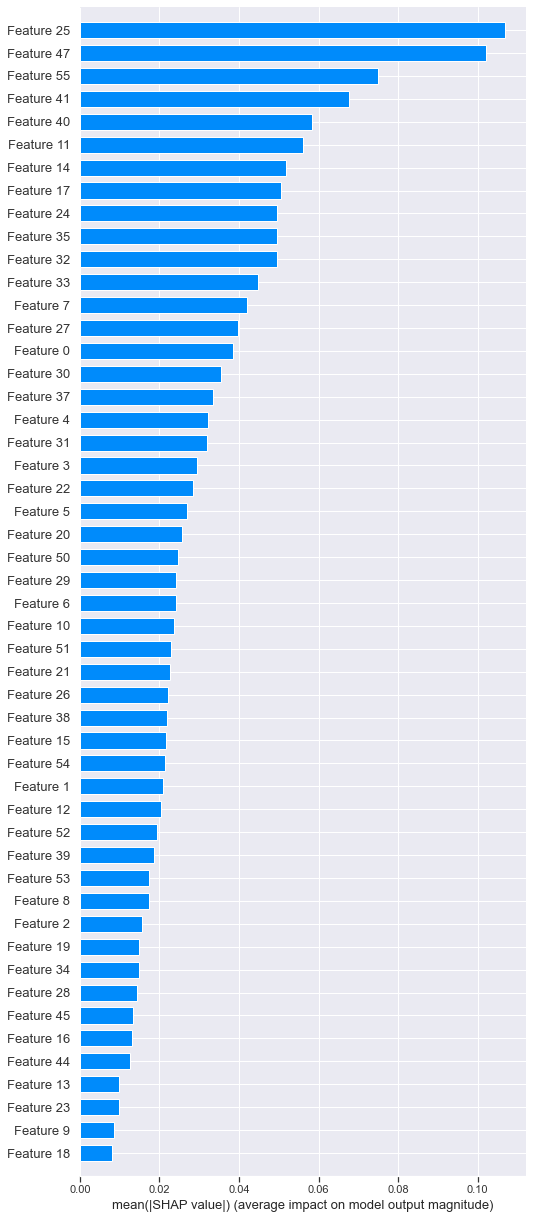

In [99]:
shap.summary_plot(shap_values, X_filtered, plot_type='bar', max_display = 50)

# Scaling and Transforming Holdout File 

In [79]:
holdout_df = pd.read_csv('Clean_holdout_file_ID.csv', low_memory=False)
holdout_df = holdout_df.drop(['Unnamed: 0'], axis = 1)

In [80]:
col_list = ['bh_ncdm_ind','bh_ncal_ind','race_cd']


counter = 0
for col in col_list:
    holdout_df[col] = holdout_df[col].astype(str)
    print(f"{counter} {col} --> {holdout_df[col].unique()} --> {holdout_df[col].dtypes}")
    counter += 1 

0 bh_ncdm_ind --> ['0' '1'] --> object
1 bh_ncal_ind --> ['0' '1'] --> object
2 race_cd --> ['1.0' '2.0' '0.0' '4.0' '3.0' '5.0' '6.0'] --> object


In [81]:
holdout_df1 = holdout_df.copy(deep = True)

In [82]:
counter = 1
for col in holdout_df1.columns:
    if holdout_df1[col].dtypes != 'object' and holdout_df1[col].skew() > 50 :   # Can possibly add .nunique to prevent categorical column transformation
        print(f"{counter}--{col} --> {holdout_df1[col].skew()}")
        holdout_df1.drop(col, inplace=True, axis =1)
        counter += 1

1--rx_gpi2_01_pmpm_cost_0to3m_b4 --> 85.05551795753992
2--auth_3mth_acute_inj --> 200.6811478085042
3--auth_3mth_acute_hdz --> 120.58641459687941


In [83]:
counter = 1
for col in holdout_df1.columns:
    if holdout_df1[col].dtypes != 'object' and holdout_df1[col].skew() > 10:
        print(f"{counter}--{col} --> {holdout_df1[col].skew()}")
        holdout_df1[col] = np.log(holdout_df1[col]+1)
        print(f"{counter}--{col} --> {holdout_df1[col].skew()}")
        counter += 1

1--rx_bh_mbr_resp_pmpm_cost_9to12m_b4 --> 26.066880432060564
1--rx_bh_mbr_resp_pmpm_cost_9to12m_b4 --> 2.8015288184662896
2--atlas_pct_laccess_nhna15 --> 40.6124346168365
2--atlas_pct_laccess_nhna15 --> 6.913843361630532
3--cmsd2_sns_digest_abdomen_pmpm_ct --> 12.917853758998763
3--cmsd2_sns_digest_abdomen_pmpm_ct --> 5.897196834449025
4--total_outpatient_allowed_pmpm_cost_6to9m_b4 --> 15.312788872876126
4--total_outpatient_allowed_pmpm_cost_6to9m_b4 --> 1.31322692290928
5--rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4 --> 19.68964262961121
5--rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4 --> 1.5418295988749617
6--ccsp_236_pct --> 11.504463414934312
6--ccsp_236_pct --> 7.897795434232756
7--rx_nonmaint_mbr_resp_pmpm_cost --> 24.2581551710432
7--rx_nonmaint_mbr_resp_pmpm_cost --> 1.1239690115668377
8--rx_gpi2_02_pmpm_cost --> 26.488648583895788
8--rx_gpi2_02_pmpm_cost --> 4.806554405370588
9--rev_pm_obsrm_pmpm_ct --> 14.253505222951267
9--rev_pm_obsrm_pmpm_ct --> 9.428448678467173
10--rx_nonbh_mbr

In [84]:
def race(x):
    if x == '1.0':
        return 'White'
    else:
        return 'Others'

holdout_df1["race_cd"] = np.vectorize(race)(holdout_df1['race_cd'])

In [85]:
holdout_df1_ID = holdout_df1[['ID']]
holdout_df2 = holdout_df1.drop("ID", axis =1)

In [86]:
holdout_df2.isnull().sum()

atlas_pct_laccess_child15                   0
atlas_pct_free_lunch14                      0
total_bh_copay_pmpm_cost_t_9-6-3m_b4        0
cons_chmi                                   0
mcc_ano_pmpm_ct_t_9-6-3m_b4                 0
                                           ..
atlas_pct_laccess_white15                   0
rx_gpi2_66_pmpm_ct                          0
rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4    0
atlas_low_education_2015_update             0
race_cd                                     0
Length: 229, dtype: int64

In [ ]:
holdout_df2_prepared_filtered = feat_selector.transform(holdout_df2_prepared)

In [ ]:
result = pd.DataFrame(clf_boruta_2.predict_proba(holdout_df2_prepared_filtered)[:, 1])

In [ ]:
result.head(5)

In [ ]:
final_result = pd.merge(holdout_df1_ID, result, left_index=True, right_index=True)

In [ ]:
final_result['Score'] = final_result[0]

In [ ]:
final_result.drop(columns=0, inplace = True)

In [ ]:
final_result.sort_values(by = 'Score', ascending=False ,inplace = True)

In [ ]:
final_result.reset_index(inplace=True,drop=True)

In [ ]:
final_result['Rank'] = final_result['Score'].rank(method='first', ascending=False)

In [ ]:
final_result.head(5)

In [ ]:
final_result.to_csv('2021CaseCompetition_Vasudev_Trivedi_20211009.csv')

In [ ]:
from sklearn.model_selection import GridSearchCV
PARAMETERS = {"subsample":[0.5, 0.75, 1],
"colsample_bytree":[0.5, 0.75, 1],
"max_depth":[2, 6, 12],
"min_child_weight":[1,5,15],
"learning_rate":[0.3, 0.1, 0.05, 0.01],
"n_estimators":[100,500,1000]}